In [ ]:
# To see which GPU has being used. Colab Pro offers Tesla-P100 as the best processor.
!nvidia-smi

Thu Sep 29 17:08:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Unzipping the dataset file preprocessed_spectograms.zip

combined_faces_zip_path = "/content/drive/MyDrive/global-ai-hub-bootcamp/preprocessed_spectograms.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping preprocessed_spectograms.zip')

Done unzipping preprocessed_spectograms.zip


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/global-ai-hub-bootcamp/cleaned_metadata.csv")
df.head()

,Unnamed: 0,fold,classID,filename
0,0,5,3,/content/spectograms/3/100032-3-0-0.png
1,1,5,2,/content/spectograms/2/100263-2-0-117.png
2,2,5,2,/content/spectograms/2/100263-2-0-121.png
3,3,5,2,/content/spectograms/2/100263-2-0-126.png
4,4,5,2,/content/spectograms/2/100263-2-0-137.png


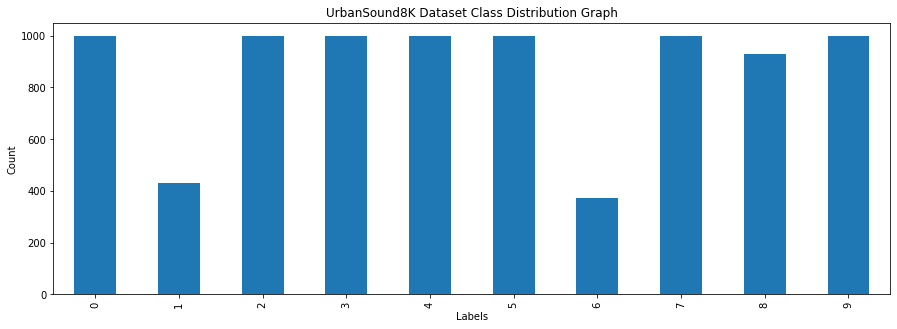

In [ ]:
df.classID.value_counts().sort_index().plot(kind="bar", figsize=(15,5))
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("UrbanSound8K Dataset Class Distribution Graph")
plt.show()

In [ ]:
# Creating train, validation and test sets.

X_train, X_temp, y_train, y_temp = train_test_split(df["filename"], df["classID"], test_size=0.2, stratify=df["classID"])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [ ]:
# Creating tensors of datasets.

train_filenames_tensor = tf.constant(list(X_train))
train_labels_tensor = tf.constant(list(y_train))

val_filenames_tensor = tf.constant(list(X_val))
val_labels_tensor = tf.constant(list(y_val))

test_filenames_tensor = tf.constant(list(X_test))
test_labels_tensor = tf.constant(list(y_test))

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.

num_classes = 10

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale.
    image_resized = tf.image.resize(image_decoded, [512, 512])
    image_normalized = tf.image.per_image_standardization(image_resized)
    label = tf.one_hot(label, num_classes)

    return image_normalized, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(batch_size)    # Same as batch_size hyperparameter in model.fit() below.

val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames_tensor, val_labels_tensor))
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.batch(batch_size)    # Same as batch_size hyperparameter in model.fit() below.


test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(batch_size)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

model = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(512, 512, 1)))    # 3rd dim = 1 for grayscale images.
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.125))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.125))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.125))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.125))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.125))
model.add(BatchNormalization())

# Output layer with 7 nodes (equal to the no. of classes).
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 510, 510, 16)      160       
                                                                 
 average_pooling2d_10 (Avera  (None, 255, 255, 16)     0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_14 (Bat  (None, 255, 255, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 253, 253, 32)      4640      
                                                                 
 average_pooling2d_11 (Avera  (None, 126, 126, 32)     0         
 gePooling2D)                                                    
                                                      

In [ ]:
# Compiling the above created CNN architecture.
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])

In [ ]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/512-gray-urbansounds-v0.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
# Fitting the above created CNN model for 50 epochs.

model_history = model.fit(train_dataset,
                                  batch_size=batch_size,
                                  validation_data=val_dataset,
                                  epochs=50,
                                  callbacks=[checkpoint],
                                  shuffle=True    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 1.7708 - accuracy: 0.3941
Epoch 1: val_accuracy improved from -inf to 0.35281, saving model to /content/drive/My Drive/512-gray-urbansounds-v0.h5
55/55 [==============================] - 25s 407ms/step - loss: 1.7708 - accuracy: 0.3941 - val_loss: 2.0479 - val_accuracy: 0.3528
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 1.2414 - accuracy: 0.5815
Epoch 2: val_accuracy did not improve from 0.35281
55/55 [==============================] - 18s 317ms/step - loss: 1.2414 - accuracy: 0.5815 - val_loss: 2.0312 - val_accuracy: 0.2841
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 1.0002 - accuracy: 0.6679
Epoch 3: val_accuracy did not improve from 0.35281
55/55 [==============================] - 18s 317ms/step - loss: 1.0002 - accuracy: 0.6679 - val_loss: 2.1888 - val_accuracy: 0.3345
Epoch 4/50
55/55 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.7031
Epoch 

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

Text(0.5, 0.92, 'Eğitim aşamasaının doğruluk oranı ve kayıp değeri')

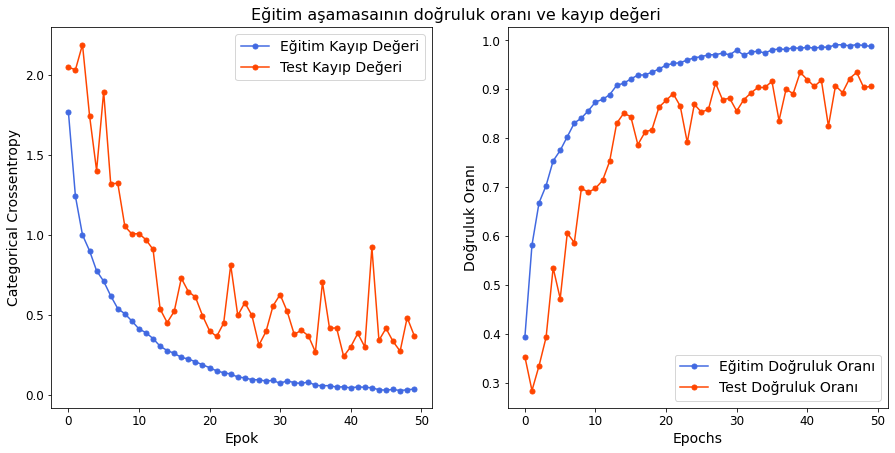

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Eğitim Kayıp Değeri', color='royalblue', marker='o', markersize=5)
ax[0].plot(val_loss, label='Test Kayıp Değeri', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epok', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Eğitim Doğruluk Oranı', color='royalblue', marker='o', markersize=5)
ax[1].plot(val_accuracy, label='Test Doğruluk Oranı', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Doğruluk Oranı', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Eğitim aşamasaının doğruluk oranı ve kayıp değeri", fontsize=16)

In [ ]:
model_score = model.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 2s 311ms/step - loss: 0.3784 - accuracy: 0.9085


In [ ]:
# Printing the relevant score summary.

model_labels = model.metrics_names
print(f'CNN model {model_labels[0]} \t\t= {round(model_score[0], 3)}')
print(f'CNN model {model_labels[1]} \t= {round(model_score[1], 3)}')

CNN model loss 		= 0.378
CNN model accuracy 	= 0.908


In [ ]:
# Generating predictions from the model above.

model_pred = model.predict(test_dataset)
model_pred = model_pred.argmax(axis=-1)

In [ ]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(y_test, model_pred)
conf_mat

array([[95,  0,  1,  0,  0,  0,  0,  2,  0,  2],
       [ 0, 41,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 2,  0, 92,  0,  0,  0,  0,  1,  3,  2],
       [ 4,  0,  9, 67,  7,  0,  7,  0,  4,  2],
       [ 0,  0,  1,  0, 93,  0,  0,  4,  2,  0],
       [ 3,  1,  0,  0,  2, 91,  0,  2,  1,  0],
       [ 0,  0,  0,  0,  2,  0, 36,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0, 97,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0, 90,  2],
       [ 3,  1,  1,  0,  3,  0,  0,  0,  0, 92]])

In [ ]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Gerçek etiket', fontsize=14)
    plt.xlabel('Tahmin edilen etiket', fontsize=14)

Normalized confusion matrix


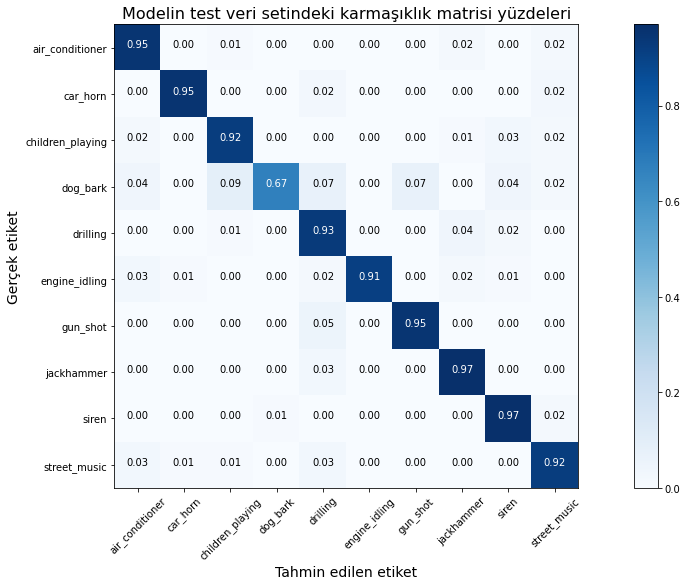

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['air_conditioner', 'car_horn','children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer',
                  'siren', 'street_music']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Modelin test veri setindeki karmaşıklık matrisi yüzdeleri")

plt.show()

Confusion matrix, without normalization


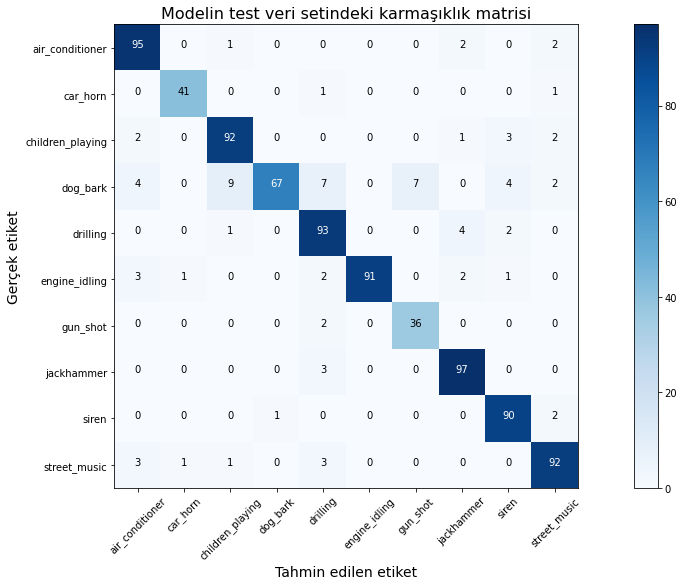

In [ ]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['air_conditioner', 'car_horn','children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer',
                  'siren', 'street_music']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=False,
                      title="Modelin test veri setindeki karmaşıklık matrisi")

plt.show()